<a href="https://colab.research.google.com/github/hideto7007/python_image-classification/blob/main/original_%E7%94%BB%E5%83%8F%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNモデル(自前画像)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim

import torch.utils.data as data

import torchvision

import glob
import os.path as osp
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

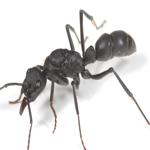

In [ ]:
img = Image.open("/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/train/ants/000001_r.jpg").convert('RGB')
img

In [ ]:
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [ ]:
# パスの確認

#a = '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/train/ants/000001_r.jpg'
#a[67:71]

b = '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000060_r.jpg'
b[65:69]


#c = './data/hymenoptera_data/train/ants/470127037_513711fd21.jpg'
#c[30:34]

'hati'

In [ ]:
from torchvision import transforms

img = Image.open("/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/train/ants/000001_r.jpg").convert('RGB')
img

class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)



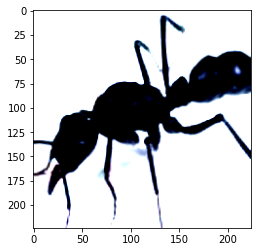

In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train") # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [ ]:
img_transformed_array = np.array(img_transformed)
img_transformed_array.shape

(224, 224, 3)

In [ ]:
# ファイルパス

def make_datapath_list(phase="train"):

    rootpath = "/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")


train_list
val_list

/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/train/**/*.jpg
/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/**/*.jpg


['/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000061_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000055_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000056_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000071_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000070_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000063_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000072_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000051_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000064_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000067_r.jpg',
 '/content/drive/MyDrive/python/deep_learning/PyTorch/img_data/val/hati/000062_r.jpg',
 '/content/drive/MyDrive/python/deep_learni

# DataSet作成

In [ ]:
class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB')  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[67:71]
        elif self.phase == "val":
            label = img_path[65:69]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "hati":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
1


In [ ]:

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.5)   # ← 左にコードを追記  
# 画像の余白領域を消去。RandomErasing(p=0.5)⇒ランダムで50%の領域が消去させる or されない

transform_train = transforms.Compose([affine, flip, to_tensor, normalize, erase])
transform_test = transforms.Compose([to_tensor, normalize])


train_dataset_1 = HymenopteraDataset(train_dataset, transform=transform_train, phase='train')

val_dataset_1 = HymenopteraDataset(val_dataset, transform=transform_test, phase='val') 

# DataLoaderの設定
batch_size = 32
train_loader = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=False)

print(train_loader)

# DataLoader作成

In [ ]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)
print(train_dataloader)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0])


# Linear⇒in_features=〇〇〇〇値は画像モデルごとに変更する

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc1 = nn.Linear(32*1*2809, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.25)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc3 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        # ------- 以下にコードを書く -------
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*1*2809)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # ------- ここまで -------
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


size値で割り切れるようにする為、self.fc1 = nn.Linear(32×1×2809)に変更

In [ ]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(val_dataloader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(60):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_dataloader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.2883770205080509 Loss_Test: 0.9054877758026123
Epoch: 1 Loss_Train: 0.33265939354896545 Loss_Test: 0.8380740880966187
Epoch: 2 Loss_Train: 0.3159290235489607 Loss_Test: 0.5755276083946228
Epoch: 3 Loss_Train: 0.17908219434320927 Loss_Test: 0.795245349407196
Epoch: 4 Loss_Train: 0.21287161111831665 Loss_Test: 0.963569164276123
Epoch: 5 Loss_Train: 0.14652612525969744 Loss_Test: 1.0222163200378418
Epoch: 6 Loss_Train: 0.1644293712452054 Loss_Test: 0.9771844744682312
Epoch: 7 Loss_Train: 0.2292041201144457 Loss_Test: 0.8559160232543945
Epoch: 8 Loss_Train: 0.37746739387512207 Loss_Test: 1.2351112365722656
Epoch: 9 Loss_Train: 0.11288009583950043 Loss_Test: 2.27817964553833
Epoch: 10 Loss_Train: 0.15841908752918243 Loss_Test: 3.2189106941223145
Epoch: 11 Loss_Train: 0.188997570425272 Loss_Test: 3.6433467864990234
Epoch: 12 Loss_Train: 0.11152632674202323 Loss_Test: 6.009763240814209
Epoch: 13 Loss_Train: 0.21788809235295048 Loss_Test: 3.441446304321289
Epoch: 14 Loss

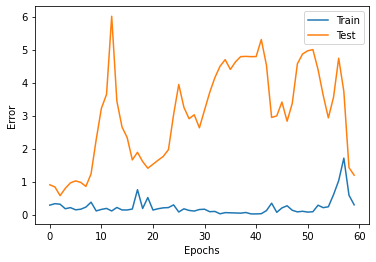

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
y_test.shape

torch.Size([32, 2])

In [ ]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(val_dataloader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 70.83333333333334%


In [ ]:
# 学習モデル保存

import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn_ants_hati.pth")  

conv1.weight :  torch.Size([8, 3, 5, 5])
conv1.bias :  torch.Size([8])
conv2.weight :  torch.Size([32, 8, 5, 5])
conv2.bias :  torch.Size([32])
fc1.weight :  torch.Size([256, 89888])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([128, 256])
fc2.bias :  torch.Size([128])
fc3.weight :  torch.Size([64, 128])
fc3.bias :  torch.Size([64])
fc4.weight :  torch.Size([2, 64])
fc4.bias :  torch.Size([2])
tensor([[[-0.1253, -0.0743,  0.0513, -0.1158, -0.0138],
         [-0.1123, -0.1559,  0.0264, -0.1487,  0.0218],
         [-0.0258, -0.0986, -0.0562,  0.0517, -0.0896],
         [-0.0437, -0.0756, -0.0464, -0.0278, -0.1475],
         [-0.0635, -0.0404, -0.1215, -0.0144, -0.0673]],

        [[-0.0183,  0.1095,  0.0193,  0.0063,  0.0450],
         [ 0.0993,  0.0084,  0.0256,  0.1189, -0.0054],
         [-0.1000,  0.0043,  0.1066, -0.0225,  0.0509],
         [-0.0536,  0.0872,  0.0917,  0.0149,  0.0878],
         [ 0.0623,  0.0493,  0.1064, -0.0273, -0.0646]],

        [[-0.0430, -0.0863, -